In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
if False:
    from sklearn.datasets import fetch_openml
    
    df0 = fetch_openml(data_id=45106, as_frame=True)
    df = df0.data
    df["claim_nb"] = df0.target
else:
    df = pd.read_parquet("df.parquet")
df

,year,town,driver_age,car_weight,car_power,car_age,claim_nb
0,2018.0,1.0,51.0,1760.0,173.0,3.0,0
1,2019.0,1.0,41.0,1760.0,248.0,2.0,0
2,2018.0,1.0,25.0,1240.0,111.0,2.0,0
3,2019.0,0.0,40.0,1010.0,83.0,9.0,0
4,2018.0,0.0,43.0,2180.0,169.0,5.0,0
...,...,...,...,...,...,...,...
999995,2019.0,1.0,45.0,1090.0,62.0,2.0,0
999996,2019.0,1.0,45.0,1180.0,93.0,4.0,0
999997,2018.0,1.0,31.0,1060.0,57.0,1.0,0
999998,2019.0,1.0,28.0,1910.0,149.0,0.0,0


## Univariate description

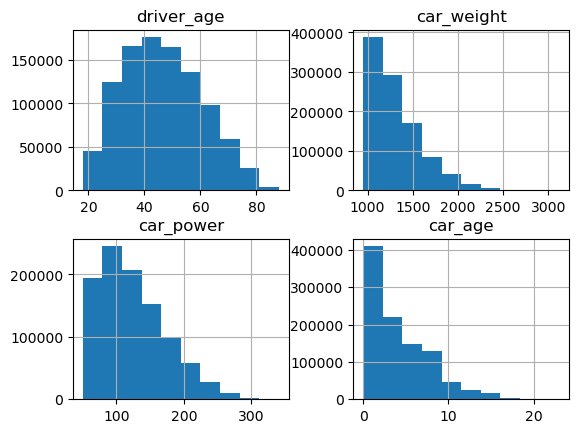

In [3]:
_ = df.hist(["driver_age", "car_weight", "car_power", "car_age"])

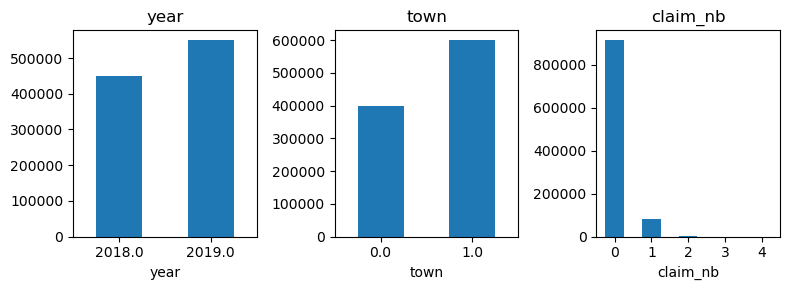

In [10]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=3)

for v, ax in zip(["year", "town", "claim_nb"], axes):
    df[v].value_counts(sort=False).sort_index().plot(kind="bar", ax=ax, rot=0, title=v)

plt.tight_layout()
plt.show()

## Data split

In [11]:
from sklearn.model_selection import train_test_split

y_train, y_test, X_train, X_test = train_test_split(
    df["claim_nb"], df.drop("claim_nb", axis=1), test_size=0.1, random_state=30
)

## LightGBM model (unconstrained)

In [40]:
# Todo: Cross-validation

import lightgbm as lgb

params = dict(
    learning_rate=0.05,
    objective="poisson",
    metric="poisson",
    num_leaves=7,
    min_data_in_leaf=50,
    min_sum_hessian_in_leaf=0.001,
    colsample_bynode=0.8,
    bagging_fraction=0.8,
    lambda_l1=3,
    lambda_l2=5,
    num_threads=7,
)

In [53]:
dtrain = lgb.Dataset(X_train, label=y_train)

model = lgb.train(params, train_set=dtrain, num_boost_round=300)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 6
[LightGBM] [Info] Start training from score -2.414908


### SHAP analysis

In [54]:
X_explain = X_train.sample(n=2000, random_state=937)

In [55]:
import shap

explainer = shap.Explainer(model)
shap_val = explainer(X_explain)

#### SHAP importance

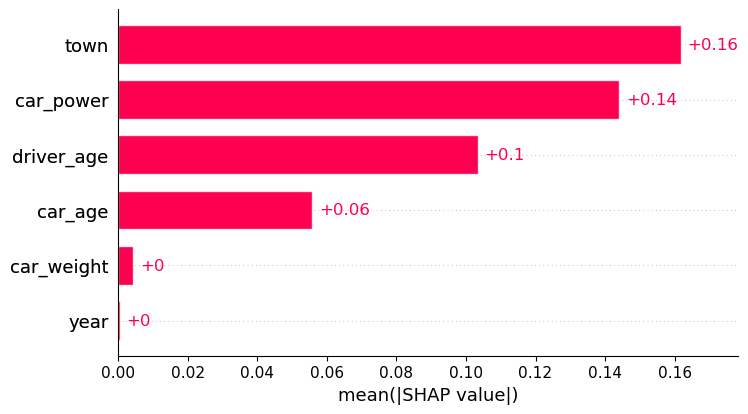

In [56]:
shap.plots.bar(shap_val)

#### SHAP dependence

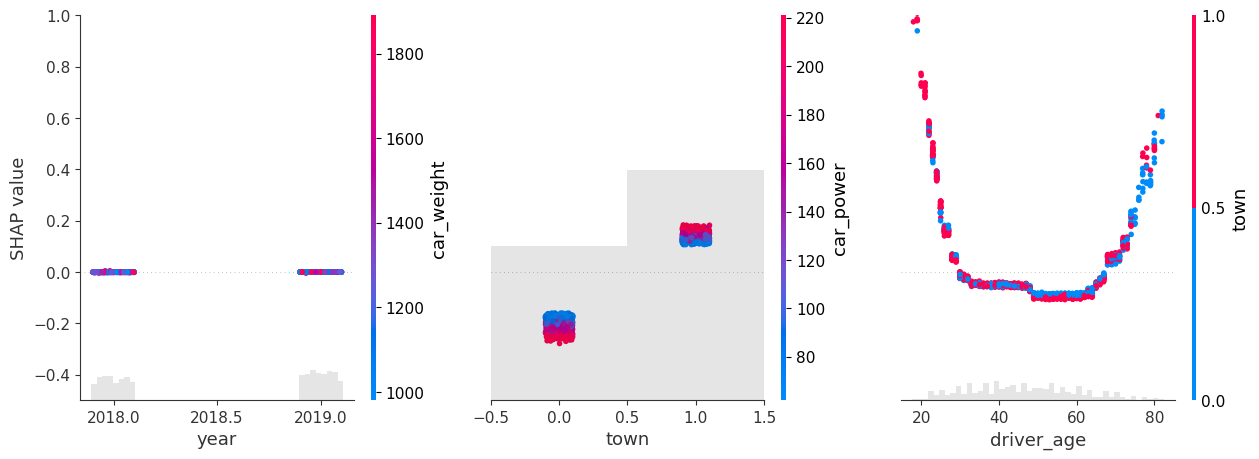

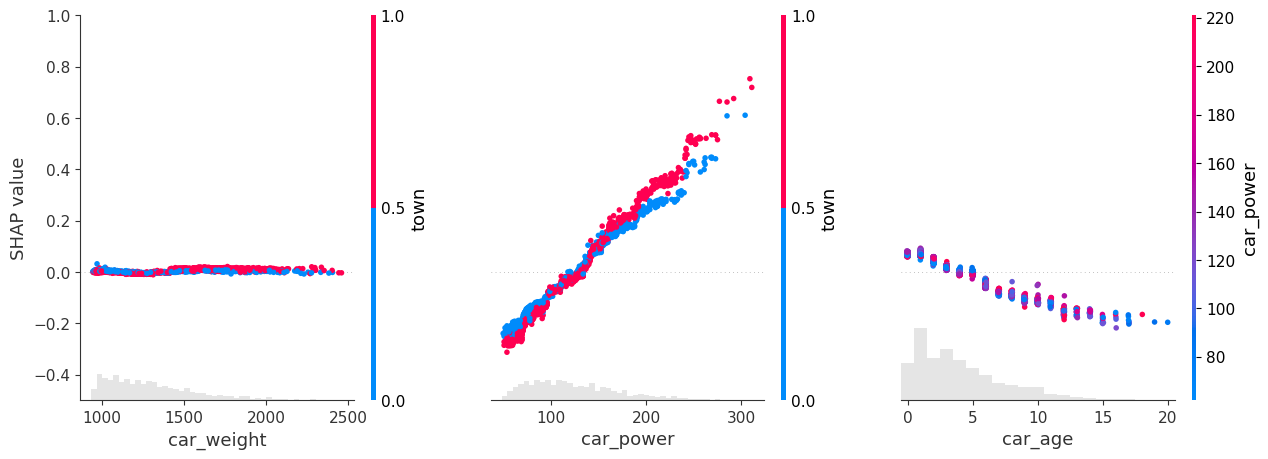

In [57]:
shap.plots.scatter(shap_val[:, 0:3], color=shap_val, ymin=-0.5, ymax=1)
shap.plots.scatter(shap_val[:, 3:], color=shap_val, ymin=-0.5, ymax=1)

## Interaction constraints

Let's keep `driver_age` and `car_age` additive, meaning that some trees use only `driver_age`, some only `car_age`, and the other trees use the rest. Why could this be interesting?

In [71]:
params_ic = params | {"interaction_constraints": [[2], [5], [0, 1, 3, 4]]}  # Mind the positions...
params_ic

{'learning_rate': 0.05,
 'objective': 'poisson',
 'metric': 'poisson',
 'num_leaves': 7,
 'min_data_in_leaf': 50,
 'min_sum_hessian_in_leaf': 0.001,
 'colsample_bynode': 0.8,
 'bagging_fraction': 0.8,
 'lambda_l1': 3,
 'lambda_l2': 5,
 'num_threads': 7,
 'interaction_constraints': [[2], [5], [0, 1, 3, 4]]}

In [72]:
model_ic = lgb.train(params_ic, train_set=dtrain, num_boost_round=300)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 6
[LightGBM] [Info] Start training from score -2.414908


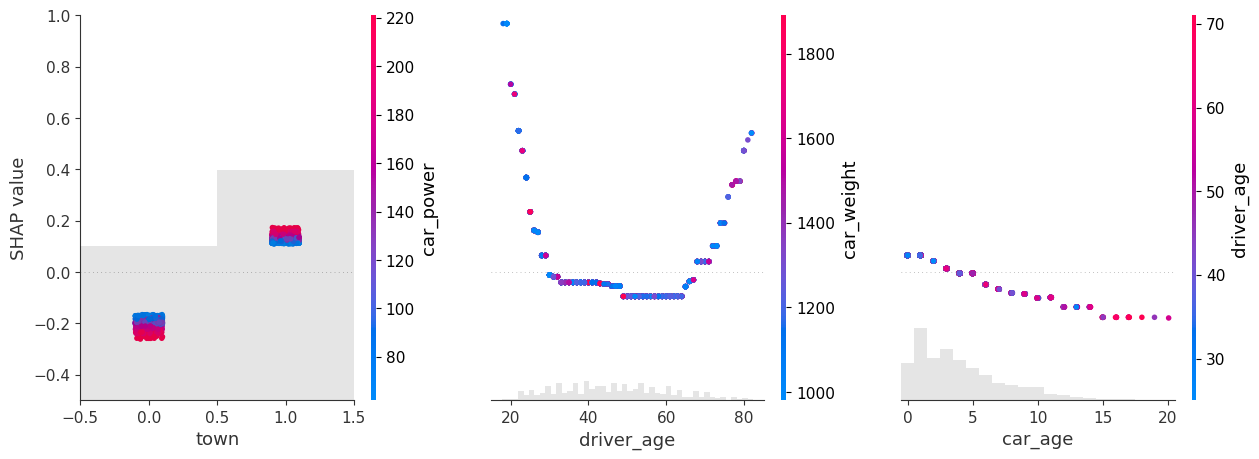

In [79]:
explainer_ic = shap.Explainer(model_ic)
shap_val_ic = explainer_ic(X_explain)

shap.plots.scatter(shap_val_ic[:, [1, 2, 5]], color=shap_val_ic, ymin=-0.5, ymax=1)

Note: Partial dependence plot of `driver_age`, on log scale, is identical. 

Show it via DALEX?

## Monotone constraints

- Don't put too many monotonicity constraints: Are apartment prices really monotonically increasing in the number of rooms, keeping the living area fixed? No!
- In SHAP plots only visible for additive features.
- Otherwise need to check individual conditional expectation (ICE) plots (disaggregated partial dependence). TODO

In [80]:
params_mc = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, -1]}  # Mind the positions...
params_mc

{'learning_rate': 0.05,
 'objective': 'poisson',
 'metric': 'poisson',
 'num_leaves': 7,
 'min_data_in_leaf': 50,
 'min_sum_hessian_in_leaf': 0.001,
 'colsample_bynode': 0.8,
 'bagging_fraction': 0.8,
 'lambda_l1': 3,
 'lambda_l2': 5,
 'num_threads': 7,
 'interaction_constraints': [[2], [5], [0, 1, 3, 4]],
 'monotone_constraints': [0, 0, 0, 0, 1, -1]}

In [81]:
model_mc = lgb.train(params_mc, train_set=dtrain, num_boost_round=300)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 6
[LightGBM] [Info] Start training from score -2.414908


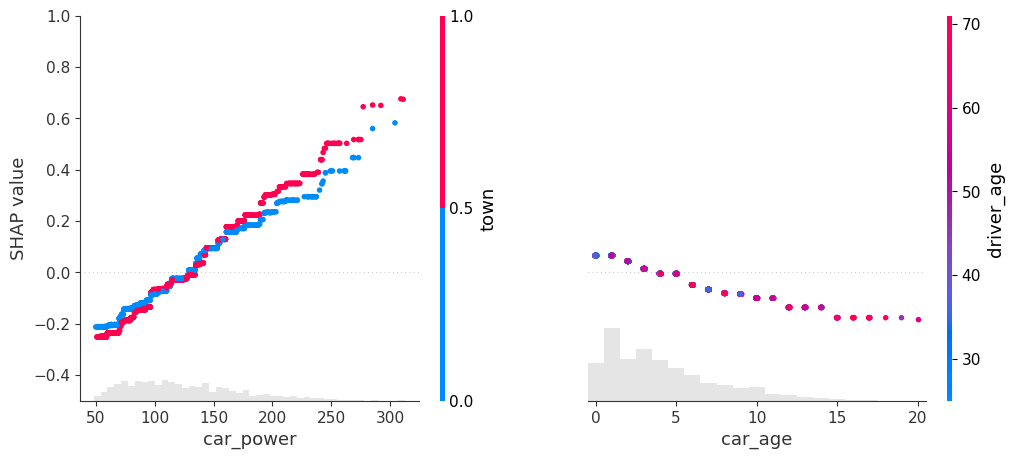

In [85]:
explainer_mc = shap.Explainer(model_mc)
shap_val_mc = explainer_mc(X_explain)

shap.plots.scatter(shap_val_mc[:, [4, 5]], color=shap_val_mc, ymin=-0.5, ymax=1)

## Monotonic constraints gone wrong

Define them correctly!

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 6
[LightGBM] [Info] Start training from score -2.414908


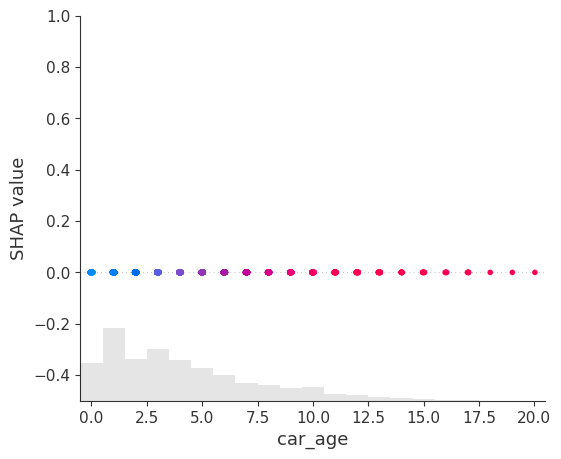

In [91]:
params_mc2 = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, 1]}  # Oops

model_mc2 = lgb.train(params_mc2, train_set=dtrain, num_boost_round=300)

explainer_mc2 = shap.Explainer(model_mc2)
shap_val_mc2 = explainer_mc2(X_explain)

shap.plots.scatter(shap_val_mc2[:, [5]], color=shap_val_mc2, ymin=-0.5, ymax=1)